# Initializing

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from typing import Iterable, Optional, Union
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.validation import check_is_fitted
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import (train_test_split, 
                                    RandomizedSearchCV, 
                                    StratifiedKFold)
from sklearn.metrics import recall_score
from sklearn.metrics import (classification_report, 
                            f1_score, 
                            confusion_matrix)
from collections import Counter


In [3]:
df = pd.read_csv('historical.csv')
df.head()

,tid,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,outcome
0,49b18cea-beb8-413d-b268-a0ec12a4147c,1.423808,-0.377568,0.242070,-0.697073,-0.763104,-0.731960,-0.367360,-0.278617,-0.996840,...,-0.469381,-0.810630,0.034175,-0.063592,0.252775,0.975686,-0.047713,0.008093,10.00,0
1,0d1de000-6756-4441-8133-e0ed75b72979,0.386691,1.932803,-1.958157,1.795148,0.597989,-1.752021,0.567382,0.225227,-0.614899,...,-0.037188,0.066752,0.232243,0.269168,-0.566513,-0.403250,0.151074,-0.044239,3.99,0
2,dc548f8c-ecd2-4fee-8a80-f2de7e2c7bd6,-0.822247,1.349695,-2.533342,-1.510371,2.429420,3.097419,-0.337696,1.778629,-0.306968,...,-0.280728,-0.954416,0.226719,0.589009,-0.325611,0.173346,0.110327,-0.006745,14.55,0
3,f105abf5-0c4c-4e79-9a8a-59de254e58dc,-0.679009,0.452323,1.256676,-1.163474,-0.871992,-0.413326,-0.319045,0.414021,-1.479641,...,0.171611,0.365879,-0.164711,0.366073,0.089739,-0.314979,-0.185542,-0.032110,10.00,0
4,164a2881-40c6-43ba-b53e-cd1e5a9e8cee,1.174152,-0.493073,-0.136508,-1.375827,-0.506841,-0.760343,0.066490,-0.174785,1.165490,...,-0.061790,-0.016600,-0.226672,0.107551,0.738778,-0.010159,-0.008166,0.006128,68.54,0


In [4]:
df = df.drop(columns = ['tid'])

# EDA

Our overall goal in the EDA is to guide the choice of preprocessing techniques. To do this, we will examine the extent of class imbalance and look for patterns that distinguish fraudulent from non-fraudulent transactions.

## Univariate

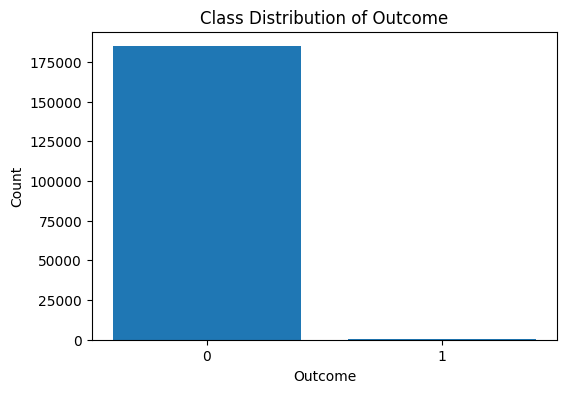

In [ ]:
# Count values
class_counts = df["outcome"].value_counts().sort_index()

# Plot
plt.figure(figsize=(6,4))
plt.bar(class_counts.index.astype(str), class_counts.values)
plt.title("Class Distribution of Outcome")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


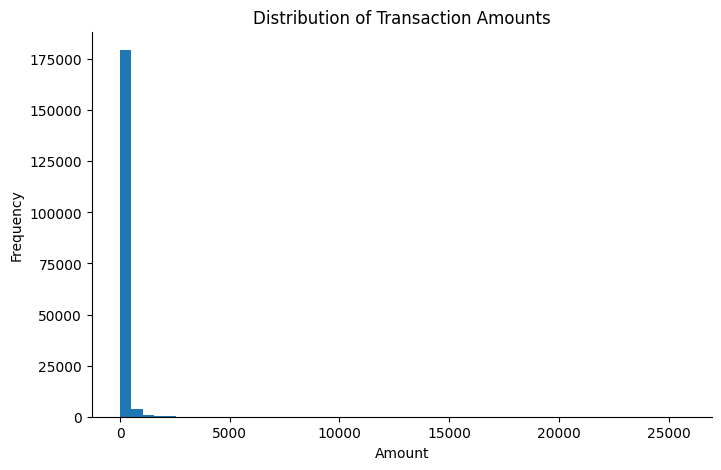

In [19]:
plt.figure(figsize=(8,5))
plt.hist(df["Amount"], bins=50)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Amount")
plt.ylabel("Frequency")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


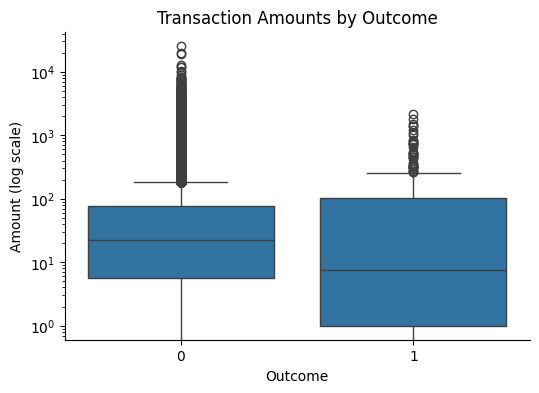

In [21]:
plt.figure(figsize=(6,4))

sns.boxplot(
    x="outcome",
    y="Amount",
    data=df
)
plt.yscale("log")  # handle skewness
plt.title("Transaction Amounts by Outcome")
plt.xlabel("Outcome")
plt.ylabel("Amount (log scale)")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


## Bivariate

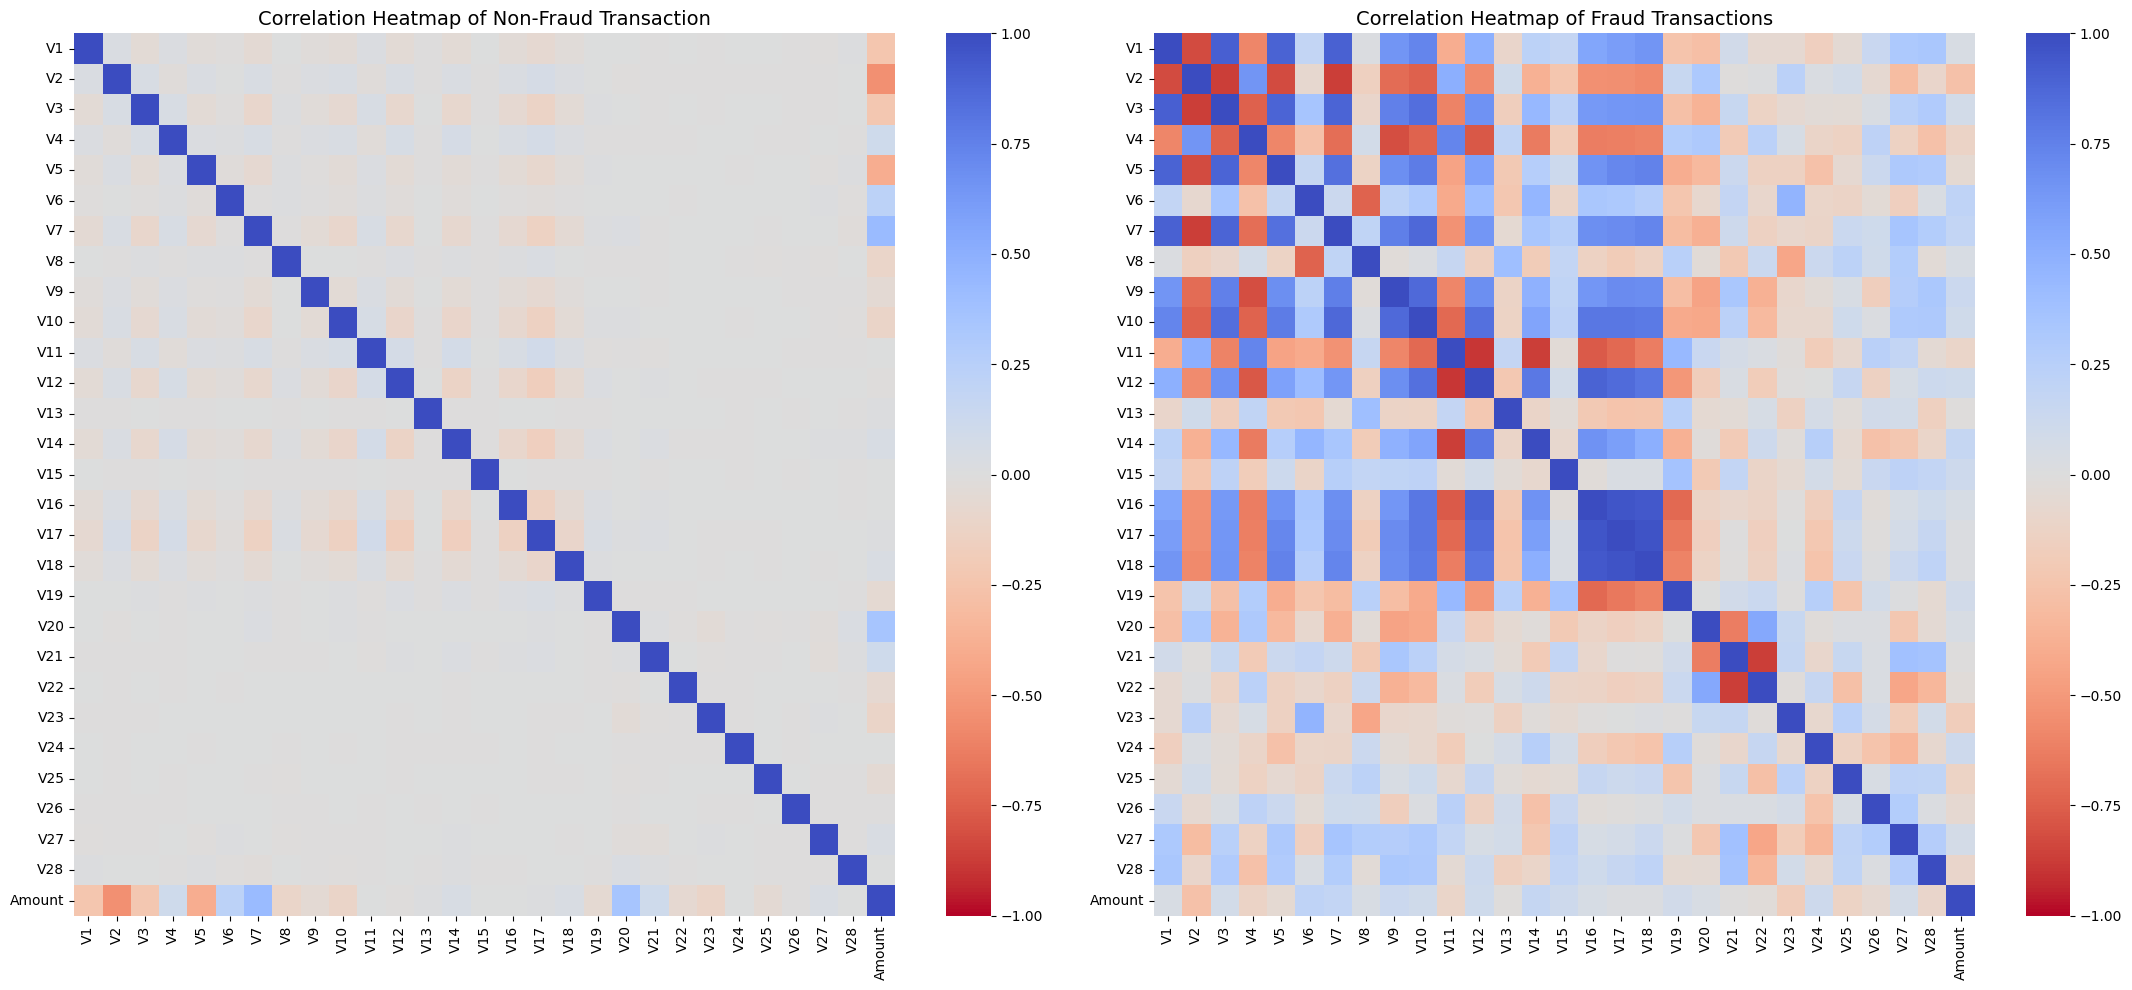

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Split datasets
is_fraud = df["outcome"] == 1
df_0 = df[~is_fraud]
df_1 = df[is_fraud]

# Compute correlation matrices
corr_0 = df_0.iloc[:, :-1].corr()
corr_1 = df_1.iloc[:, :-1].corr()

# Plot side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(22, 10))

sns.heatmap(
    corr_0,
    cmap="coolwarm_r",
    vmax=1,
    vmin=-1,
    center=0,
    annot=False,
    cbar=True,
    ax=axes[0]
)
axes[0].set_title("Correlation Heatmap of Non-Fraud Transaction", fontsize=14)

sns.heatmap(
    corr_1,
    cmap="coolwarm_r",
    vmax=1,
    vmin=-1,
    center=0,
    annot=False,
    cbar=True,
    ax=axes[1]
)
axes[1].set_title("Correlation Heatmap of Fraud Transactions", fontsize=14)

plt.tight_layout()
plt.show()

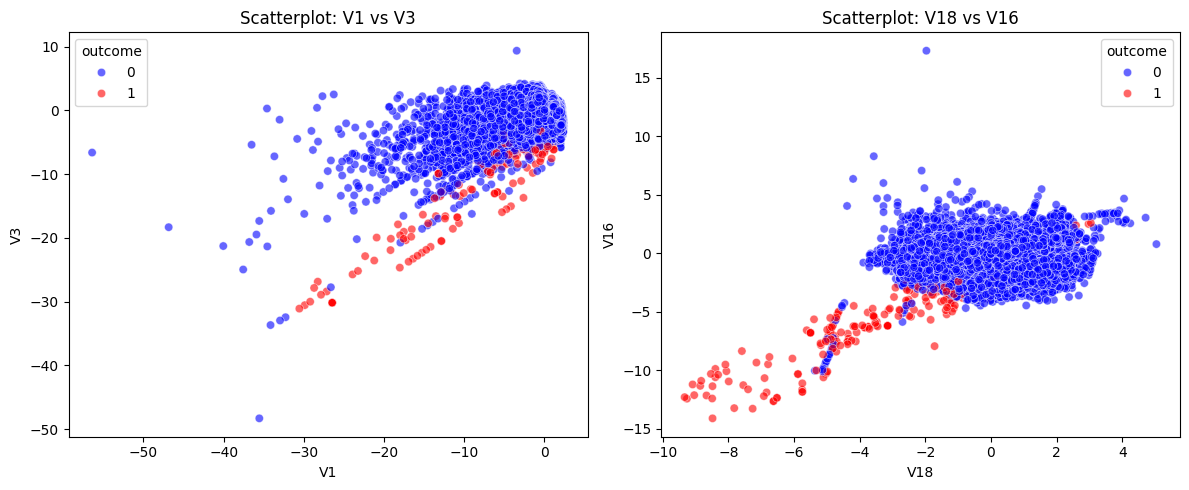

In [17]:
plt.figure(figsize=(12,5))

# V1 vs V3
plt.subplot(1,2,1)
sns.scatterplot(
    data=df,
    x="V1", y="V3",
    hue="outcome",
    alpha=0.6,
    palette={0: "blue", 1: "red"}
)
plt.title("Scatterplot: V1 vs V3")

# V18 vs V16
plt.subplot(1,2,2)
sns.scatterplot(
    data=df,
    x="V18", y="V16",
    hue="outcome",
    alpha=0.6,
    palette={0: "blue", 1: "red"}
)
plt.title("Scatterplot: V18 vs V16")

plt.tight_layout()
plt.show()

# Data Preprocessing

In [13]:
# Count of nulls per column
df.isnull().sum()

V1         0
V2         0
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
Amount     0
outcome    0
dtype: int64

In [14]:
df.duplicated().sum()

np.int64(4670)

In [15]:
df_clean = df.drop_duplicates()

# Baseline

We use 3-way split

In [24]:
target = df["outcome"]

X, y = df.iloc[:, :-1], df.iloc[:, -1]

# Test set (Hold-out)
X_Train, X_test, y_Train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=target
)

# Train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_Train, y_Train, test_size=0.2, random_state=0, stratify=y_Train
)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X shape: {X.shape}")

X_train shape: (118479, 29)
X_val shape: (29620, 29)
X_test shape: (37025, 29)
X shape: (185124, 29)


In [25]:
def RF_Class(x_val, x_train, x_test, y_val, y_train, y_test):
    lr = RandomForestClassifier(n_estimators=500, random_state=36).fit(x_train, y_train)

    # Predictions on test set
    y_pred = lr.predict(x_test)

    # Base metrics
    class_report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Custom metrics
    recall_fraud = class_report['1']['recall']  # detection rate for fraud class
    detection_rate = recall_fraud
    fraud_capture_rate = recall_fraud * 100

    # Net value gained/loss (amount is last column in x_test)
    amount_test = x_test.iloc[:, -1]
    caught_value = amount_test[(y_test == 1) & (y_pred == 1)].sum()
    missed_value = amount_test[(y_test == 1) & (y_pred == 0)].sum()
    false_positive_value = amount_test[(y_test == 0) & (y_pred == 1)].sum()
    net_value = caught_value - missed_value - false_positive_value

    # Print results
    print("Classification Report:")
    print(classification_report(y_test, y_pred))  # pretty string format

    print(f"Detection Rate (Recall for fraud): {detection_rate:.4f}")
    print(f"Fraud Capture Rate: {fraud_capture_rate:.2f}%")
    print(f"Net Value Gained/Loss: {net_value:,.2f}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=lr.classes_, yticklabels=lr.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return class_report, conf_matrix, detection_rate, fraud_capture_rate, net_value

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36961
           1       0.98      0.66      0.79        64

    accuracy                           1.00     37025
   macro avg       0.99      0.83      0.89     37025
weighted avg       1.00      1.00      1.00     37025

Detection Rate (Recall for fraud): 0.6562
Fraud Capture Rate: 65.62%
Net Value Gained/Loss: 3,271.89


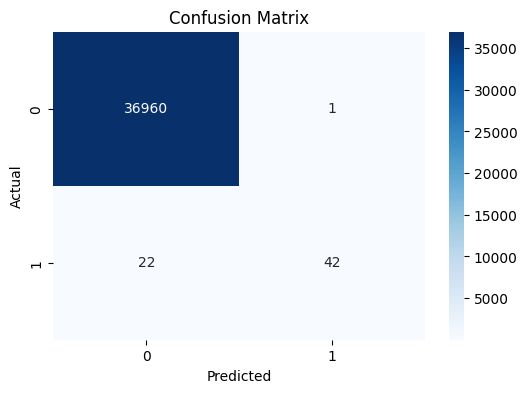

({'0': {'precision': 0.9994051160023796,
   'recall': 0.9999729444549661,
   'f1-score': 0.9996889495963107,
   'support': 36961.0},
  '1': {'precision': 0.9767441860465116,
   'recall': 0.65625,
   'f1-score': 0.7850467289719626,
   'support': 64.0},
  'accuracy': 0.9993787981093856,
  'macro avg': {'precision': 0.9880746510244456,
   'recall': 0.828111472227483,
   'f1-score': 0.8923678392841367,
   'support': 37025.0},
  'weighted avg': {'precision': 0.9993659451849002,
   'recall': 0.9993787981093856,
   'f1-score': 0.9993179272568115,
   'support': 37025.0}},
 array([[36960,     1],
        [   22,    42]]),
 0.65625,
 65.625,
 3271.890000000001)

In [ ]:
RF_Class(X_val, X_train,X_test, y_val, y_train,y_test)


Additional Notes 
- Please follow how prof did it in his ntbk
- kindly include as well how it looked like before and after smote using scatterplot 
- include hyperparameter tuning for k (untuned vs tuned metrics as well)
- include additional metric for fraud capture rate 
                               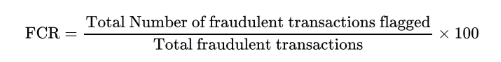

# Handle Class Imbalance

Let us first use random undersampling.

In [43]:
rus = RandomUnderSampler(random_state=37)
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)

us_model = Pipeline(
   [
        ("clf", RandomForestClassifier(
            n_estimators=500,
            max_depth=None,
            random_state=37,
            n_jobs=-1
        ))
    ]
)

us_model.fit(X_train_us, y_train_us)
us_preds = us_model.predict(X_val)

# Predictions already computed: us_preds

# Confusion matrix
conf_matrix = confusion_matrix(y_val, us_preds)

# Base classification report
print("Random Under Sampling Performance on the Validation Set:\n")
print(f"Validation F1 Score: {f1_score(y_val, us_preds):.4f}")
print(classification_report(y_val, us_preds))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(conf_matrix))

# --- Custom Metrics ---
# Detection rate (recall for fraud class)
recall_fraud = recall_score(y_val, us_preds, pos_label=1)
detection_rate = recall_fraud
fraud_capture_rate = recall_fraud * 100

# Net value gained/loss
amount_val = X_val.iloc[:, -1]  # last column assumed to be "Amount"

caught_value = amount_val[(y_val == 1) & (us_preds == 1)].sum()
missed_value = amount_val[(y_val == 1) & (us_preds == 0)].sum()
false_positive_value = amount_val[(y_val == 0) & (us_preds == 1)].sum()
net_value = caught_value - missed_value - false_positive_value

# Print custom metrics
print(f"Detection Rate (Recall for fraud): {detection_rate:.4f}")
print(f"Fraud Capture Rate (FCR): {fraud_capture_rate:.2f}%")
print(f"Net Value Gained/Loss: {net_value:,.2f}")



Random Under Sampling Performance on the Validation Set:

Validation F1 Score: 0.1175
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     29569
           1       0.06      0.94      0.12        51

    accuracy                           0.98     29620
   macro avg       0.53      0.96      0.55     29620
weighted avg       1.00      0.98      0.99     29620

Validation Set Confusion Matrix:
        0    1
0  28851  718
1      3   48
Detection Rate (Recall for fraud): 0.9412
Fraud Capture Rate (FCR): 94.12%
Net Value Gained/Loss: -251,777.75


In [45]:
# --- Apply SMOTE ---
sm = SMOTE(random_state=37)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

# --- Random Forest Classifier ---
sm_model = Pipeline(
   [
        ("clf", RandomForestClassifier(
            n_estimators=500,
            max_depth=None,
            random_state=37,
            n_jobs=-1
        ))
    ]
)

sm_model.fit(X_train_sm, y_train_sm)
sm_preds = sm_model.predict(X_val)

# --- Confusion matrix ---
conf_matrix = confusion_matrix(y_val, sm_preds)

# --- Base metrics ---
print("SMOTE Performance on the Validation Set:\n")
print(f"Validation F1 Score: {f1_score(y_val, sm_preds):.4f}")
print(classification_report(y_val, sm_preds))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(conf_matrix))

# --- Custom Metrics ---
# Detection rate (recall for fraud class)
recall_fraud = recall_score(y_val, sm_preds, pos_label=1)
detection_rate = recall_fraud
fraud_capture_rate = recall_fraud * 100

# Net value gained/loss
amount_val = X_val.iloc[:, -1]  # last column assumed to be "Amount"

caught_value = amount_val[(y_val == 1) & (sm_preds == 1)].sum()
missed_value = amount_val[(y_val == 1) & (sm_preds == 0)].sum()
false_positive_value = amount_val[(y_val == 0) & (sm_preds == 1)].sum()
net_value = caught_value - missed_value - false_positive_value

# --- Print custom metrics ---
print(f"Detection Rate (Recall for fraud): {detection_rate:.4f}")
print(f"Fraud Capture Rate (FCR): {fraud_capture_rate:.2f}%")
print(f"Net Value Gained/Loss: {net_value:,.2f}")


SMOTE Performance on the Validation Set:

Validation F1 Score: 0.8627
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29569
           1       0.86      0.86      0.86        51

    accuracy                           1.00     29620
   macro avg       0.93      0.93      0.93     29620
weighted avg       1.00      1.00      1.00     29620

Validation Set Confusion Matrix:
        0   1
0  29562   7
1      7  44
Detection Rate (Recall for fraud): 0.8627
Fraud Capture Rate (FCR): 86.27%
Net Value Gained/Loss: 1,408.19


In [47]:
from imblearn.over_sampling import ADASYN

# --- Apply ADASYN ---
adasyn = ADASYN(random_state=37)
X_train_as, y_train_as = adasyn.fit_resample(X_train, y_train)

# --- Random Forest Classifier ---
as_model = Pipeline(
   [
        ("clf", RandomForestClassifier(
            n_estimators=500,
            max_depth=None,
            random_state=37,
            n_jobs=-1
        ))
    ]
)

as_model.fit(X_train_as, y_train_as)
as_preds = as_model.predict(X_val)

# --- Confusion matrix ---
conf_matrix = confusion_matrix(y_val, as_preds)

# --- Base metrics ---
print("ADASYN Performance on the Validation Set:\n")
print(f"Validation F1 Score: {f1_score(y_val, as_preds):.4f}")
print(classification_report(y_val, as_preds))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(conf_matrix))

# --- Custom Metrics ---
# Detection rate (recall for fraud class)
recall_fraud = recall_score(y_val, as_preds, pos_label=1)
detection_rate = recall_fraud
fraud_capture_rate = recall_fraud * 100

# Net value gained/loss
amount_val = X_val.iloc[:, -1]  # last column assumed to be "Amount"

caught_value = amount_val[(y_val == 1) & (as_preds == 1)].sum()
missed_value = amount_val[(y_val == 1) & (as_preds == 0)].sum()
false_positive_value = amount_val[(y_val == 0) & (as_preds == 1)].sum()
net_value = caught_value - missed_value - false_positive_value

# --- Print custom metrics ---
print(f"Detection Rate (Recall for fraud): {detection_rate:.4f}")
print(f"Fraud Capture Rate (FCR): {fraud_capture_rate:.2f}%")
print(f"Net Value Gained/Loss: {net_value:,.2f}")


ADASYN Performance on the Validation Set:

Validation F1 Score: 0.8627
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29569
           1       0.86      0.86      0.86        51

    accuracy                           1.00     29620
   macro avg       0.93      0.93      0.93     29620
weighted avg       1.00      1.00      1.00     29620

Validation Set Confusion Matrix:
        0   1
0  29562   7
1      7  44
Detection Rate (Recall for fraud): 0.8627
Fraud Capture Rate (FCR): 86.27%
Net Value Gained/Loss: 1,408.19


In [46]:
caught_value - missed_value

1706.7300000000005

# Modeling

# Using Test.csv

Please use the test.csv file and include the output based on our model and export it in a csv file